In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
root_dir = 'data/facialpoint/training/'
data = pd.read_csv('data/facialpoint/training_frames_keypoints.csv')

In [5]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2, numpy as np
from copy import deepcopy
class FacesData(Dataset):
    def __init__(self, df, root_dir=root_dir):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = root_dir + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_img(self, ix):
        img_path = root_dir + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img


In [10]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True), root_dir)
val_dataset = FacesData(val.reset_index(drop=True), root_dir)

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)

In [6]:
# 這裡改用ResNet(還在寫 XD)
def get_ResNet_model():
    model = models.resnet18(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 136),
      nn.Sigmoid()
    )
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [6]:
def get_model():
    model = models.vgg16(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential( nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten())
    model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
    )
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [8]:
model, criterion, optimizer = get_model()

In [9]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [10]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [11]:
train_loss, test_loss = [], []
n_epochs = 30

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} / {n_epochs}")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(val_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
    print(f"train loss: {epoch_train_loss:.4f} test loss: {epoch_test_loss:.4f}")

 epoch 1 / 30
train loss: 0.0713 test loss: 0.0465
 epoch 2 / 30
train loss: 0.0553 test loss: 0.0386
 epoch 3 / 30
train loss: 0.0477 test loss: 0.0333
 epoch 4 / 30
train loss: 0.0423 test loss: 0.0295
 epoch 5 / 30
train loss: 0.0381 test loss: 0.0284
 epoch 6 / 30
train loss: 0.0351 test loss: 0.0266
 epoch 7 / 30
train loss: 0.0327 test loss: 0.0242
 epoch 8 / 30
train loss: 0.0315 test loss: 0.0242
 epoch 9 / 30
train loss: 0.0293 test loss: 0.0227
 epoch 10 / 30
train loss: 0.0283 test loss: 0.0242
 epoch 11 / 30
train loss: 0.0289 test loss: 0.0239
 epoch 12 / 30
train loss: 0.0266 test loss: 0.0219
 epoch 13 / 30
train loss: 0.0262 test loss: 0.0250
 epoch 14 / 30
train loss: 0.0263 test loss: 0.0235
 epoch 15 / 30
train loss: 0.0265 test loss: 0.0252
 epoch 16 / 30
train loss: 0.0271 test loss: 0.0243
 epoch 17 / 30
train loss: 0.0247 test loss: 0.0225
 epoch 18 / 30
train loss: 0.0229 test loss: 0.0215
 epoch 19 / 30
train loss: 0.0221 test loss: 0.0244
 epoch 20 / 30
train 

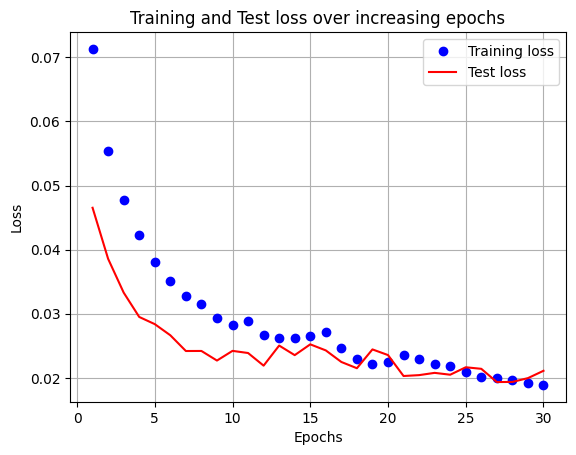

In [12]:
epochs = np.arange(n_epochs)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

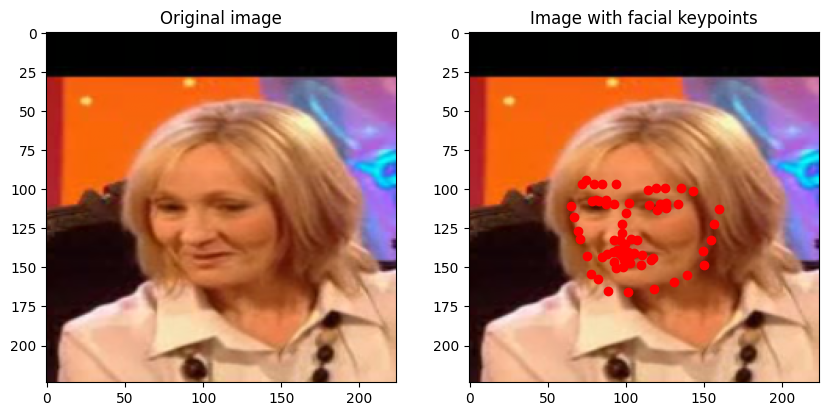

In [11]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = val_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = val_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [ ]:
# save model
torch.save(model.state_dict(), '05_5_Facial_keypoints_detection_VGG16model.pth')

#### 載入先前訓練的模型比較結兼

In [7]:
model,_,_ = get_model()
model.load_state_dict(torch.load('05_5_Facial_keypoints_detection_VGG16model.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

filename = Albert_Brooks_30.jpg


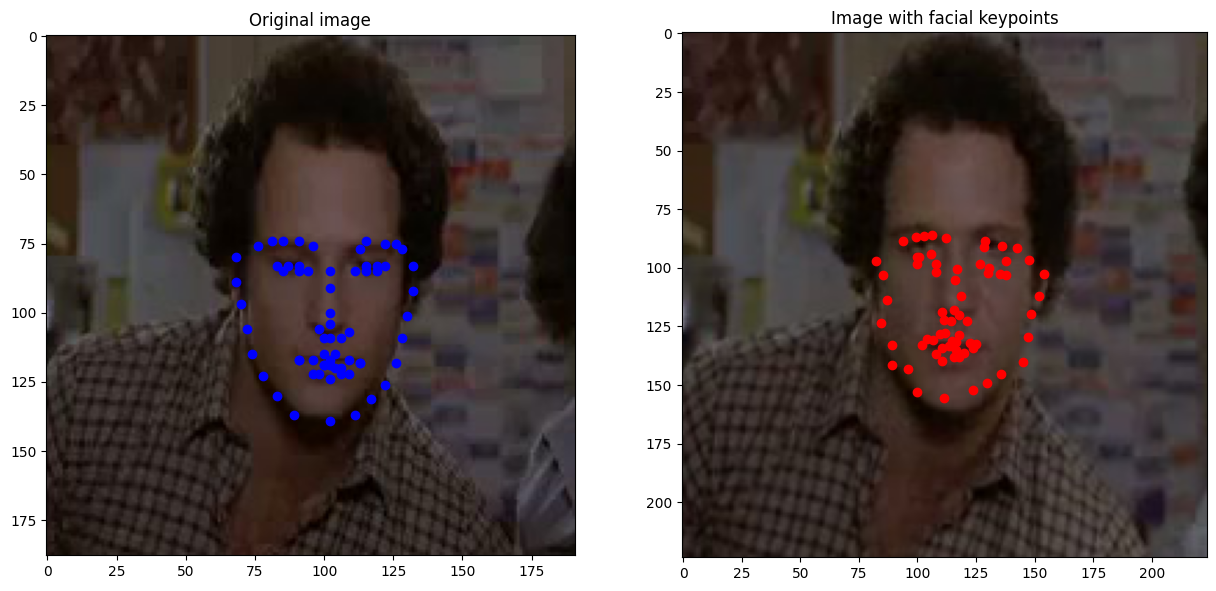

In [13]:
# 在测试集上的表现
# 正確答案在test_frames_keypoints.csv裡，使用藍色點表示
# 預測答案使用紅色點表示
import random
test = pd.read_csv('data/facialpoint/test_frames_keypoints.csv')
ix = random.randint(0,769) #有770張圖片
file_name = test.iloc[ix,0]
print(f'filename = {file_name}')
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Original image')
im = cv2.imread('data/facialpoint/test/'+file_name)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
okp = deepcopy(test.iloc[ix,1:].tolist())
plt.scatter(np.array(okp[0::2]), np.array(okp[1::2]), c='b')
plt.grid(False)

plt.subplot(222)
test_dataset = FacesData(test.reset_index(drop=True), root_dir='data/facialpoint/test/')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')